1. normalize the luminance values
2. resize the images to a standard shape

In [2]:
%matplotlib inline

import glob
from multiprocessing import Process
import os
import re

import matplotlib.pyplot as plt

import numpy as np
import PIL
from PIL import Image

In [3]:
#Processing parameters

SIZE = 150 #for ImageNet models compatibility
TRAIN_DIR = 'F:/Data Science/Dataset/DogVsCat/train/'
TEST_DIR = 'F:/Data Science/Dataset/DogVsCat/test/'
BASE_DIR = 'F:/Data Science/Dataset/DogVsCat/'

Sort numerically

In [4]:
def natural_key(string_):
    """
    Define sort key that is integer-aware
    """
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)',string_)]

Normalize the image Luminance
1. normalize the luminance (brightness) values to have mean 0 and standard deviation 1
2. apply a slight contrast stretch
3. convert RGB to YCbCr,operate on the Y channel , then convert back to RGB

In [5]:
def norm_image(img):
    """
    Normalize PIL image
    Normalize luminace to (mean,std) = (0,1),and applies a [1%,99%] contrast stretch
    """
    #convert to YCbCr
    img_y,img_b,img_r = img.convert('YCbCr').split()
    img_y_np = np.asarray(img_y).astype(float)
    
    #Normalize
    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    
    #contrast stretch
    scale = np.max([np.abs(np.percentile(img_y_np,1.0)),np.abs(np.percentile(img_y_np,99.0))])
    img_y_np = img_y_np/scale
    img_y_np = np.clip(img_y_np,-1.0,1.0)
    img_y_np = (img_y_np+1.0)/2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)
    img_y = Image.fromarray(img_y_np)
    img_ybr = Image.merge('YCbCr',(img_y,img_b,img_r))
    
    #convert back to RGB
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

Resize the image

1. resize the images to be square with a default side length of 224 to be compatible with models trained on imageNet
2. The aspect ratio is preserved and gray bars are added as necessary to make the image square

In [6]:
def resize_image(img,size):
    """
    Resize PIL image
    Resizes image to be square with sidelength size. Pads with gray if needed
    """
    #Resize : 1. retain the image ratio
    n_x,n_y = img.size
    if(n_y> n_x):
        n_y_new = size
        n_x_new = int(size*n_x/n_y+0.5)
    else:
        n_x_new = size
        n_y_new = int(size*n_y/n_x + 0.5)
    
    #2. square
    #n_x_new = size
    #n_y_new = size
    
    img_res = img.resize((n_x_new,n_y_new),resample = PIL.Image.BICUBIC)
    
    #Pad the borders to create a square image
    img_pad = Image.new('RGB',(size,size),(0,0,0))
    ulc = ((size-n_x_new)//2,(size-n_y_new)//2)
    img_pad.paste(img_res,ulc)
    
    return img_pad    

Accumulate the Image names

In [7]:
train_cats = sorted(glob.glob(os.path.join(TRAIN_DIR,'cat*.jpg')),key = natural_key)
train_dogs = sorted(glob.glob(os.path.join(TRAIN_DIR,'dog*.jpg')),key = natural_key)
train_all = train_cats + train_dogs

test_all = sorted(glob.glob(os.path.join(TEST_DIR,'*.jpg')),key=natural_key)

Preprocess a Single Image
1. preprocess a single image
2. display before and after version

20266


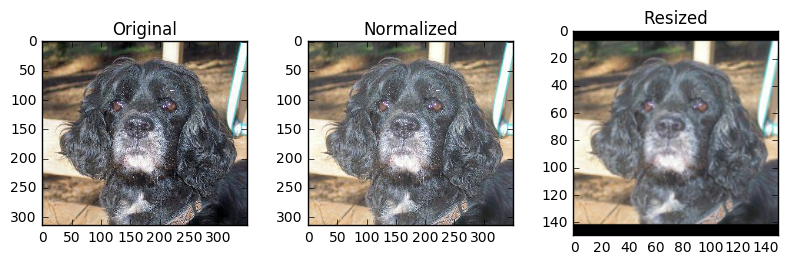

In [8]:
#Read the image
choose_random_image = True
if choose_random_image:
    idx = np.random.randint(0,len(train_all))
else:
    idx = 24000

print (idx)

path = train_all[idx]
img = Image.open(path)

#Normalize it
img_nrm = norm_image(img)

#resize it
img_res = resize_image(img_nrm,SIZE)

#show it
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('Original')
plt.imshow(img)

plt.subplot(132)
plt.title('Normalized')
plt.imshow(img_nrm)

plt.subplot(133)
plt.title('Resized')
plt.imshow(img_res)

plt.tight_layout()
plt.show() 

Process Bunch Images

In [9]:
def prep_images(paths,out_dir,istrain):
    """
    Preprocess images
    Reads images in paths , and writes to out_dir
    """
    for count,path in enumerate(paths):
        if count % 1000 == 0:
            print (path)
        img = Image.open(path)
        #img_nrm = norm_image(img)
        img_res = resize_image(img,SIZE)
        basename = os.path.basename(path)
        path_out = os.path.join(out_dir,basename)
        img_res.save(path_out)
        if(istrain == 1):
            img_flip = img_res.transpose(Image.FLIP_LEFT_RIGHT)
            basename = 'flip_{}'.format(basename)
            path_out = os.path.join(out_dir,basename)
            img_flip.save(path_out)

In [10]:
import threading
def process_main():
    """
    Main program for running from command line
    """
    
    #make the output directories
    base_out = os.path.join(BASE_DIR,'data{}'.format(SIZE))
    train_dir_out = os.path.join(base_out,'train')
    test_dir_out = os.path.join(base_out,'test')
    
    os.makedirs(train_dir_out,exist_ok = True)
    os.makedirs(test_dir_out,exist_ok = True)
    
    #Preprocess the training files
    #procs = dict()
    #procs[1] = Process(target=prep_images,args = (train_cats,train_dir_out,))
    #procs[1].start()
    #procs[2] = Process(target=prep_images,args = (train_dogs,train_dir_out,))
    #procs[2].start()
    #procs[3] = Process(target=prep_images,args = (test_all,test_dir_out,))
    #procs[3].start()
    
    #procs[1].join()
    #procs[2].join()
    #procs[3].join()
    
    #Thread 
    threads = dict()
    threads[1] = threading.Thread(target = prep_images,args=(train_cats,train_dir_out,1))
    threads[1].start()
    threads[2] = threading.Thread(target = prep_images,args = (train_dogs,train_dir_out,1))
    threads[2].start()
    threads[3] = threading.Thread(target = prep_images,args = (test_all,test_dir_out,0))
    threads[3].start()
    
    threads[1].join()
    threads[2].join()
    threads[3].join()
    
    #prep_images(train_cats,train_dir_out)
    #prep_images(train_dogs,train_dir_out)
    #prep_images(test_all,test_dir_out)

In [11]:
process_main()

F:/Data Science/Dataset/DogVsCat/train\cat.0.jpg
F:/Data Science/Dataset/DogVsCat/train\dog.0.jpg
F:/Data Science/Dataset/DogVsCat/test\1.jpg
F:/Data Science/Dataset/DogVsCat/test\1001.jpg
F:/Data Science/Dataset/DogVsCat/train\dog.1000.jpg
F:/Data Science/Dataset/DogVsCat/train\cat.1000.jpg
F:/Data Science/Dataset/DogVsCat/test\2001.jpg
F:/Data Science/Dataset/DogVsCat/test\3001.jpg
F:/Data Science/Dataset/DogVsCat/train\dog.2000.jpg
F:/Data Science/Dataset/DogVsCat/train\cat.2000.jpg
F:/Data Science/Dataset/DogVsCat/test\4001.jpg
F:/Data Science/Dataset/DogVsCat/train\dog.3000.jpg
F:/Data Science/Dataset/DogVsCat/test\5001.jpg
F:/Data Science/Dataset/DogVsCat/train\cat.3000.jpg
F:/Data Science/Dataset/DogVsCat/test\6001.jpg
F:/Data Science/Dataset/DogVsCat/train\dog.4000.jpg
F:/Data Science/Dataset/DogVsCat/test\7001.jpg
F:/Data Science/Dataset/DogVsCat/train\cat.4000.jpg
F:/Data Science/Dataset/DogVsCat/train\dog.5000.jpg
F:/Data Science/Dataset/DogVsCat/test\8001.jpg
F:/Data Scienc